In [2]:
# 目标检测数据集
''' 
⽬标检测领域没有像MNIST和Fashion-MNIST那样的⼩数据集。为了快速测试⽬标检测模型，我们收集并标
记了⼀个⼩型数据集。⾸先，我们拍摄了⼀组⾹蕉的照⽚，并⽣成了1000张不同⻆度和⼤⼩的⾹蕉图像。然
后，我们在⼀些背景图⽚的随机位置上放⼀张⾹蕉的图像。最后，我们在图⽚上为这些⾹蕉标记了边界框。
---------------------------------------------------------------------------------------

'''
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l

In [3]:
# 下载数据集
# 包含所有图像和CSV标签⽂件的⾹蕉检测数据集可以直接从互联⽹下载
#@save
d2l.DATA_HUB['banana-detection'] = (
    d2l.DATA_URL + 'banana-detection.zip',
    '5de26c8fce5ccdea9f91267273464dc968d20d72')

In [4]:
# 读取数据集
'''
通过read_data_bananas函数，我们读取⾹蕉检测数据集。该数据集包括⼀个的CSV⽂件，内含⽬标类别
标签和位于左上⻆和右下⻆的真实边界框坐标
'''
#@save
def read_data_bananas(is_train=True): # 读取香蕉检测数据集
    """读取香蕉检测数据集中的图像和标签"""
    data_dir = d2l.download_extract('banana-detection') # 下载香蕉检测数据集
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train
                             else 'bananas_val', 'label.csv') # 依据is_train选择文件路径
    csv_data = pd.read_csv(csv_fname) # 读取对应路径的csv文件
    csv_data = csv_data.set_index('img_name') #  将 csv_fname 中的img_name列转化为行索引
    # print(csv_data)
    images, targets = [], []
    # print(csv_data.iterrows())
    # iterrows() 是在数据框中的行进行迭代的一个生成器，它返回每行的索引及一个包含行本身的对象
    for img_name, target in csv_data.iterrows(): # 遍历行数据将图像与对应标签读取出来
        images.append(torchvision.io.read_image(
            os.path.join(data_dir, 'bananas_train' if is_train else
                         'bananas_val', 'images', f'{img_name}'))) # 添加图像路径
        # 这里的target包含(类别，左上角x，左上角y，右下角x，右下角y),images 表示行索引
        # 其中所有图像都具有相同的香蕉类（类别为0）
        targets.append(list(target)) # 添加列表
    # TODO: Why /256 ?  edge_size=256 
    return images, torch.tensor(targets).unsqueeze(1)/256 # 返回图像张量以及对应标签(索引,对角坐标)

In [5]:
''' 
通过使⽤ read_data_bananas 函数读取图像和标签，以下BananasDataset类别将允许我们创建⼀个⾃
定义 Dataset 实例来加载⾹蕉检测数据集
'''
#@save
class BananasDataset(torch.utils.data.Dataset): # 香蕉数据集设置,用于读取训练或测试所用数据集
    """一个用于加载香蕉检测数据集的自定义数据集"""
    def __init__(self, is_train):
        # features 对应 images,labels 对应 targets
        self.features, self.labels = read_data_bananas(is_train) # 读取训练香蕉数据集 
        print('read ' + str(len(self.features)) + (f' training examples' if
              is_train else f' validation examples')) # 打印训练或测试时读取的所有图片数量

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

In [6]:
''' 
最后，我们定义load_data_bananas函数，来为训练集和测试集返回两个数据加载器实例。对于测试集，
⽆须按随机顺序读取它
'''
#@save
def load_data_bananas(batch_size): # 加载数据集,对数据进行batch划分
    """加载香蕉检测数据集"""
    # 数据加载 torch.utils.data.DataLoader主要是对数据进行batch的划分
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                           batch_size)
    return train_iter, val_iter # 返回训练以及测试所用的两个迭代器

In [12]:
'''
让我们读取⼀个⼩批量，并打印其中的图像和标签的形状。图像的⼩批量的形状为（批量⼤⼩、通道数、⾼
度、宽度），看起来很眼熟：它与我们之前图像分类任务中的相同。标签的⼩批量的形状为（批量⼤⼩，m，
5），其中 m 是数据集的任何图像中边界框可能出现的最⼤数量

⼩批量计算虽然⾼效，但它要求每张图像含有相同数量的边界框，以便放在同⼀个批量中。通常来说，图像
可能拥有不同数量个边界框；因此，在达到m之前，边界框少于m的图像将被⾮法边界框填充。这样，每个
边界框的标签将被⻓度为5的数组表⽰。数组中的第⼀个元素是边界框中对象的类别，其中-1表⽰⽤于填充的
⾮法边界框。数组的其余四个元素是边界框左上⻆和右下⻆的（x，y）坐标值（值域在0到1之间）。对于⾹蕉
数据集⽽⾔，由于每张图像上只有⼀个边界框，因此m = 1
'''
batch_size, edge_size = 32, 256 
train_iter, _ = load_data_bananas(batch_size) # 加载 batch_size 的训练数据,测试数据使用 _ 不赋予变量
# 从迭代器中获取批量
batch = next(iter(train_iter)) # next() 返回迭代器的下一个项目,与生成迭代器的iter() 函数一起使用
# batch 列表,内含图片与标签两个张量数据
batch,batch[0].shape, batch[1].shape # batch[0]表示图片的小批量,batch[1]表示标签的小批量
# (torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))  m=1

read 1000 training examples
read 100 validation examples


([tensor([[[[103., 102., 105.,  ..., 174., 162., 165.],
            [105., 103., 106.,  ..., 177., 173., 169.],
            [104., 107., 110.,  ..., 185., 178., 175.],
            ...,
            [128., 123., 130.,  ...,  13.,   1.,  11.],
            [139., 121., 130.,  ...,  14.,   4.,  20.],
            [122., 117., 126.,  ...,  16.,  14.,   9.]],
  
           [[149., 148., 147.,  ..., 189., 178., 180.],
            [150., 147., 148.,  ..., 192., 187., 185.],
            [149., 150., 149.,  ..., 200., 193., 189.],
            ...,
            [103.,  98., 106.,  ...,  61.,  49.,  61.],
            [116.,  98., 108.,  ...,  64.,  54.,  72.],
            [ 99.,  94., 104.,  ...,  66.,  66.,  61.]],
  
           [[185., 184., 187.,  ..., 212., 204., 209.],
            [189., 186., 188.,  ..., 213., 213., 211.],
            [190., 192., 190.,  ..., 219., 216., 215.],
            ...,
            [ 63.,  57.,  62.,  ...,  63.,  51.,  62.],
            [ 74.,  54.,  61.,  ...,  63.,  5

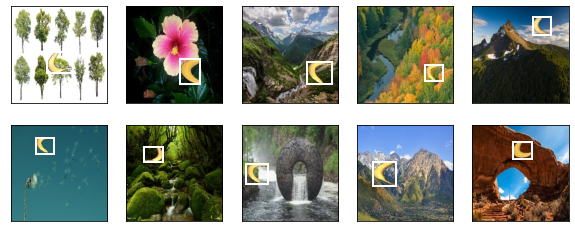

In [ ]:
# 演示
'''
让我们展⽰10幅带有真实边界框的图像。我们可以看到在所有这些图像中⾹蕉的旋转⻆度、⼤⼩和位置都有
所不同。当然，这只是⼀个简单的⼈⼯数据集，实践中真实世界的数据集通常要复杂得多

permute(dims) 将tensor的维度换位。参数是一系列的整数，代表原来张量的维度。
比如三维就有0，1，2 这些 dimension

利用 permute(0，2，1) 可以把 Tensor([[[1,2,3],[4,5,6]]]) 转换成:

tensor([[[1., 4.],
        [2., 5.],
        [3., 6.]]])
        
再比如图片img的size比如是 (28, 28, 3) 就可以利用 img.permute(2, 0, 1) 
得到一个size为 (3, 28, 28) 的 tensor
---------------------------------------------------------------------------------------
读代码的时候看到data, label = zip(*batch)这样一句，很好奇它究竟实现了什么操作
利用zip(*)命令将batch解压开，当有多个迭代器，希望它们能以相同索引一起输出时，会使用zip(*)命令
''' 
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255 # permute(dims) 将tensor的维度换位
axes = d2l.show_images(imgs, 2, 5, scale=2) # 轴域 创建子图
for ax, label in zip(axes, batch[1][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

In [ ]:
''' 
⼩结
• 我们收集的⾹蕉检测数据集可⽤于演⽰⽬标检测模型。
• ⽤于⽬标检测的数据加载与图像分类的数据加载类似。但是，在⽬标检测中，标签还包含真实边界框的
信息，它不出现在图像分类中
'''